In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os

In [136]:
# set your baseline and recall results directory
baseline_dir = "<your path>/output/default/baseline/<your model name>/ntask_nshot"
recall_dir = "<your path>/output/default/recall/<your model name>"

In [137]:
from scipy.stats import ttest_ind, ttest_rel
sign = lambda x: (1, -1)[x<0]

In [138]:
def get_loc(perm_id, permutations, task_name):
    perm_row = permutations.iloc[perm_id]
    column_number = [i for i, value in enumerate(perm_row) if value == task_name]
    return column_number[0]

In [139]:
def get_one_matrix(baseline_dir, recall_dir, n_task, n_shot):
    # return an 8x8 matrix of needle-in-a-task-haystack test...
    baseline_df = pd.read_csv(os.path.join(baseline_dir, "results.csv"), index_col=0)
    baseline_df[baseline_df["n_shot_per_class"] == n_shot]

    recall_df = pd.read_csv(os.path.join(recall_dir, "results.csv"), index_col=0)

    permutations = pd.read_csv(os.path.join(recall_dir, "permutations.csv"), index_col=0)

    task_list = recall_df["task_name"].unique().tolist()

    agg = {task_name: [[] for _ in range(len(task_list))] for task_name in task_list}
    for index, row in recall_df.iterrows():
        task_name = row["task_name"]
        loc = get_loc(row["permutation_id"], permutations, task_name)
        agg[task_name][loc].append(row["accuracy"])

    final_agg = {task_name: [[] for _ in range(len(task_list))] for task_name in task_list}
    episode_agg = {idx: [0.0 for _ in range(len(task_list))] for idx in range(5)}

    for perm_id in range(5):
        for task_name in task_list:
            sub_df = recall_df[(recall_df["task_name"] == task_name) & (recall_df["permutation_id"] == perm_id)]
            baseline_sub_df = baseline_df[(baseline_df["task_name"] == task_name) & (baseline_df["n_shot_per_class"] == n_shot)]
            loc = get_loc(perm_id, permutations, task_name)
            t, p = ttest_rel(sub_df['accuracy'], baseline_sub_df['accuracy'])
            pass_or_not = sign(t) * int(p < 0.05) # 1: pass; -1: not pass
            final_agg[task_name][loc].append(pass_or_not)
            episode_agg[perm_id][loc] = pass_or_not

    for task in task_list:
        for j in range(len(task_list)):
            final_agg[task][j] = np.mean(final_agg[task][j]) if len(final_agg[task][j])>0 else np.nan

    matrix = np.array([episode_agg[key] for key in episode_agg])
    avg_for_idx = np.mean(matrix, axis=0)

    chunks = np.array_split(avg_for_idx, 8)
    averages = np.array([np.mean(chunk) for chunk in chunks])
    
    return averages


In [140]:

n_shot = 2
all_avgs = []
for n_task in [8, 16, 24, 32, 40, 48, 56, 64]:
    _recall_dir = os.path.join(recall_dir, f"ntask{n_task}_nshot{n_shot}")

    avg = get_one_matrix(baseline_dir, _recall_dir, n_task=n_task, n_shot=n_shot)
    all_avgs.append(avg)

all_avgs = np.array(all_avgs)
scale_n_task_results = all_avgs

/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]


/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted 

In [141]:
def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'truncated({},{:.2f},{:.2f})'.format(cmap.name, min_val, max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap
cmap = truncate_colormap(plt.cm.RdBu, 0.1, 0.9)
cmap.set_bad(color='lightgrey')  # You can set this to any color you like

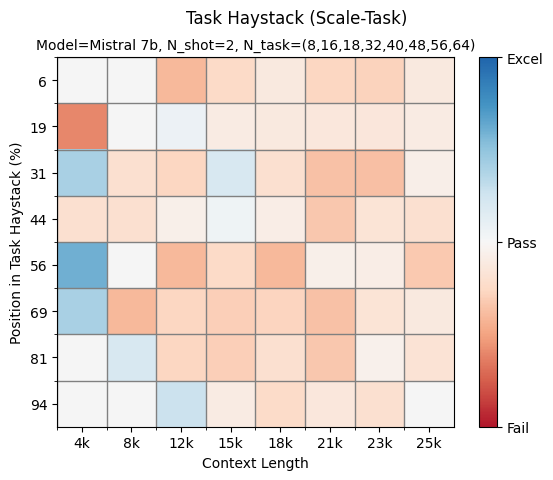

In [142]:
fig, ax = plt.subplots()
im = ax.imshow(scale_n_task_results.transpose(), cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add a color bar for reference
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1])
cbar.set_ticklabels(['Fail', 'Pass', 'Excel'])

# Add labels and title for clarity
plt.xlabel('Context Length')
plt.xticks(ticks=range(8),labels=["4k", "8k", "12k", "15k", "18k", "21k", "23k", "25k"])

interval = 100 / 16
points = np.arange(0, 100, interval)
odd_points = points[1::2] 

plt.ylabel('Position in Task Haystack (%)')
plt.yticks(ticks=range(8), labels=[round(k) for k in odd_points])
plt.suptitle('Task Haystack (Scale-Task)')
plt.title("Model=Mistral 7b, N_shot=2, N_task=(8,16,18,32,40,48,56,64)", fontsize=10)

ax.set_xticks([x-0.5 for x in range(8)], minor=True)
ax.set_yticks([y-0.5 for y in range(len(scale_n_task_results))], minor=True)

ax.grid(True, which='minor', color='grey', linestyle='-', linewidth=1)

# Show the plot
plt.show()

In [143]:
n_task = 16
all_avgs = []
for n_shot in [1,2,3,4,5,6,7,8]:
    _recall_dir = os.path.join(recall_dir, f"ntask{n_task}_nshot{n_shot}")

    avg = get_one_matrix(baseline_dir, _recall_dir, n_task=n_task, n_shot=n_shot)
    all_avgs.append(avg)

all_avgs = np.array(all_avgs)
scale_n_shot_results = all_avgs

/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]


/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]
/tmp/ipykernel_35920/1580894248.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted 

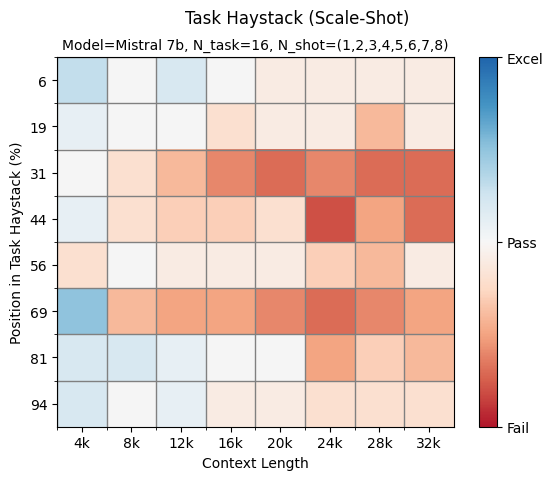

In [144]:
fig, ax = plt.subplots()
im = ax.imshow(scale_n_shot_results.transpose(), cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add a color bar for reference
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1])
cbar.set_ticklabels(['Fail', 'Pass', 'Excel'])

# Add labels and title for clarity
plt.xlabel('Context Length')
plt.xticks(ticks=range(8),labels=["{}k".format((item+1)*4) for item in range(8)])

interval = 100 / 16
points = np.arange(0, 100, interval)
odd_points = points[1::2] 

plt.ylabel('Position in Task Haystack (%)')
plt.yticks(ticks=range(8), labels=[round(k) for k in odd_points])
plt.suptitle('Task Haystack (Scale-Shot)')
plt.title("Model=Mistral 7b, N_task=16, N_shot=(1,2,3,4,5,6,7,8)", fontsize=10)

ax.set_xticks([x-0.5 for x in range(8)], minor=True)
ax.set_yticks([y-0.5 for y in range(len(scale_n_task_results))], minor=True)
ax.grid(True, which='minor', color='grey', linestyle='-', linewidth=1)


# Show the plot
plt.show()